# Diagnosing Histograms of p-values


## Introduction

* __Background__: DNA sequencing data for cancer patients, after aligned with and compared with reference genome, show differences from the reference genome. For example, at a certain position on the genome, the reference genome has a nucleotide C while the DNA sequencing data has a nucleotide A. We call this a "C > A variant". 


* __Goal__: The first question we need is ask is whether this variant is a real mutation or a sequencing error? Real mutations carry biomedical information which we want to study. The goal here is to filter out signal (real mutations) from the background of noise (sequencing errors). We need hypothesis test.


* __Hypothesis__: every C to A variant is due to sequencing error. The error rate follows the Binomial Distribution. For example, if the nucleotide in interest is C (ground truth), and this nucleotide is sequenced by $N$ times in total, the probability of mistaking C for A by $n$ times is 

    $\mathrm{Binom}(n|N,\theta) = {N!\over n! (N-n)!}\theta^n (1-\theta)^{N-n}\, ,$
    where $\theta$ is unknown.
    
    
* __Data__: Pairs of $(n, N)$. The total number of pairs is $S\simeq 1.3\times 10^5$.


* __Method__: We use 80% the data set to fit a Binomial distribution, namely fit $\theta$. Assuming hold-out part of the data set (20%) also follows the same distribution, we check how unlikely each $(n_i, N_i)$ in the hold-out part appears. We define a right-sided p-value, i.e. the `p_value` is the probability for $n\geq n_i$,

    `p_value` $= P(n\geq n_i) = \mathrm{Binom.cdf}(n_i|N_i,\theta) + \mathrm{Binom.pmf}(n_i|N_i,\theta)$.
    
    We choose right-sided `p_value` because the greater $n_i$ the more likely that it is a real mutation and the smaller `p_value`.
    

* __Expected `p_value` Histogram__: Given the definition of `p_value`, the probability for `p_value` smaller than $\alpha$ is not greater than $\alpha$, i.e.
    
    $P($ `p_value` $<\alpha)\leq \alpha$
    
    Therefore, we should expect a flat histogram if the hypothesis is true. If there are real mutations among the data set as well as sequencing errors, then the histogram should have a peak near `p_value`=0 and is flat elsewhere. Why do we have such expectations? Please see detailed explanations in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6164648/). Examples of both cases are shown below.


<img src="files/expected_p_histograms.png" width="700">

Let us look at the histogram of p-values we get under the hypothesis that the error rate follows a single Binomial Distribution. 

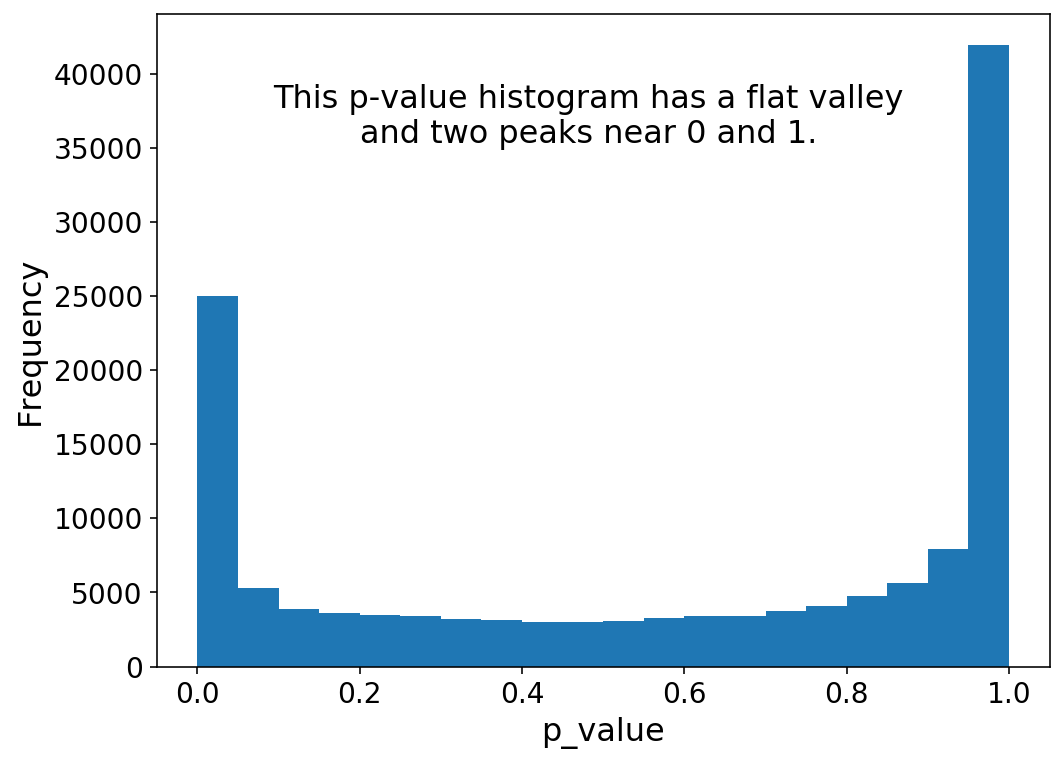

In [1]:
# First, we import some packages.
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# specify label size and tick size for all figures in this notebook
label_size = 16
tick_size = 14

# Read in file containing n, N and pvalue assuming a single binomial distribution.
# This dataframe has 3 columns. They are "n", "N" and "pvalue" respectively.
# Therefore we name it as `nNp_df_1`, where `1` means these p-values are calculated
# based on the hypothesis that the error rate follows a single Binomial Distribution.
nNp_df_1 = pd.read_csv("../Output_files/nNp_df_K1.csv")

# Make a histogram of p-value
fig, axes = plt.subplots(1, 1, figsize = (8,6))
axes.hist(nNp_df_1['pvalue'], bins = 20)
axes.set_xlabel('p_value', size = label_size)
axes.set_ylabel('Frequency', size = label_size)
axes.tick_params(labelsize = tick_size)
fig.suptitle('''This p-value histogram has a flat valley
and two peaks near 0 and 1.''', \
             y = 0.8, size = label_size, ha = 'center')
plt.show()

We need to diagnose why the p-value histogram is not as expected. There are two possible reasons.

* __Possible Reason One__: The assumption in the null hypothesis on the error rate is invalid. As a reminder, we assume that the error rate follows a signle Binomial Distribution with unknown $\theta$.


* __Possible Reason Two__: The expectation on the shape of the p-value histogram is incorrect. If the assumption about the error rate is correct and the data only contains errors, does this really lead to a flat histogram of p-values? Although we may mathematically show this, it is __easier for people to understand it by showing Monte Carlo experiments__.

## Monte Carlo Experiments

We run two Monte Carlo experiments below. 

* __Experiment One__: we artifically draw $n$ from a single Binomial Distribution, $\mathrm{Binom}(n | N, \theta = 0.01)$. Here the $N$ is drawn randomly from the DNA sequencing data. We generate $S$ paris of $(n,\, N)$ in this way. Then we calculate the p-value for each $(n,\, N)$ pair assuming a single Binomial Distribution. The resulting p-value histogram is flat.

    This experiment __excludes Possible Reason Two__ above. The details are shown below.

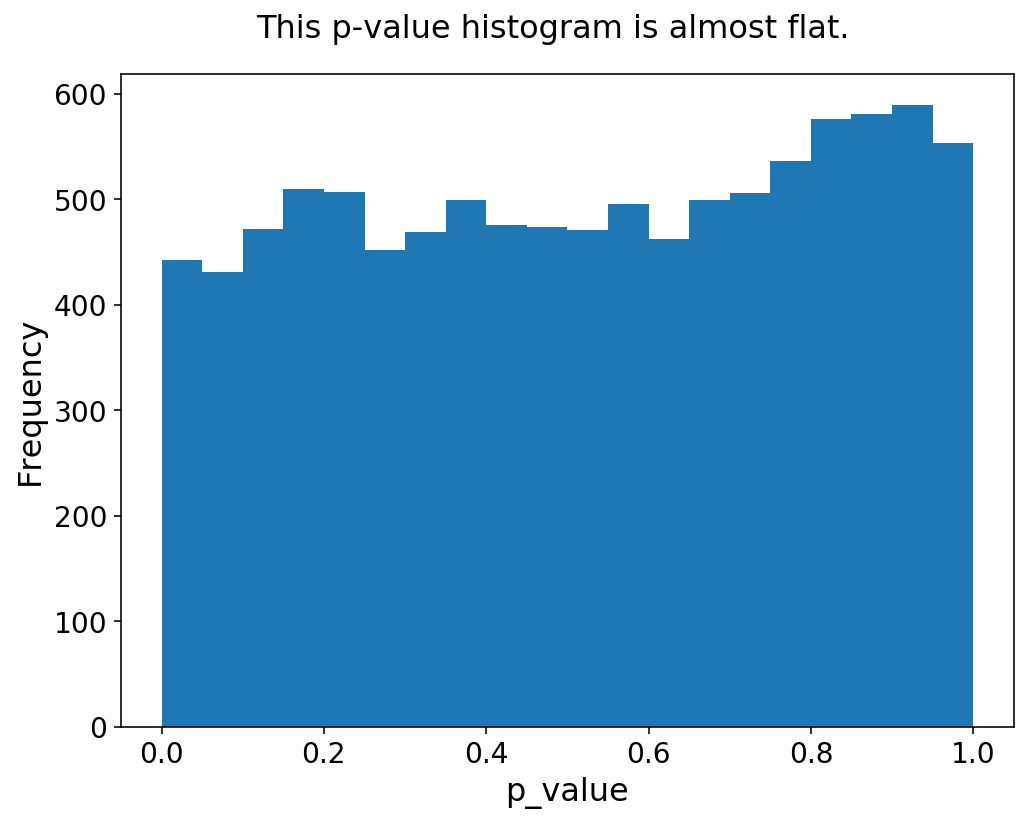

In [2]:
# ------- Step 1: Generate artifical data ----------------------

# read in the dataframe containing the DNA sequencing data.
# `chr4` here means that the DNA data is about a gene in the 4th human chromosome.
# So here `chr` refers to chromosome.
chr4_df = pd.read_csv("../Data/chr4_with_pvalues_SNP.csv")

# get the list of `N` in this dataframe `chr4_df`. 
N_list_in_dataset = (chr4_df['total_depth_frw']+chr4_df['total_depth_frw'])

# Draw S = 1e5 values of `N` from the DNA sequencing dataset randomly.
S = int(1e4)
N_list = np.random.choice(N_list_in_dataset, S)

# import Binomial Distribution from scipy.stats
from scipy.stats import binom

# specify the parameter theta.
# It corresponds to the probability of C > A error for each sequencing
theta = 0.01

# Draw a list of n. Each n is drawn randomly from the Binomail Distribution
# specifified by theta and N, i.e. Binom(N, theta)
n_list = []
for N in N_list:
    Binom = binom(N,theta)
    n = Binom.rvs(size = 1)[0]
    n_list.append(n)
    
# Convert the list to a numpy array
n_list = np.array(n_list)



#---------Step 2: Calculate p-values---------------------------------

from scipy.stats import betabinom

Ns_sum = N_list.sum()
ns_sum = n_list.sum()
p_value_list = []

for i in range(len(n_list)):
    Ni = N_list[i]
    ni = n_list[i]
    M = Ns_sum - Ni
    m = ns_sum - ni
    alpha = m + 1
    beta = M - m + 1
    
    # bbn_i means beta_binomial_for_Sample_i for the position in consideration
    bbn_i = betabinom(Ni, alpha, beta)
    
    # calculate p-value for Sample i in this row
    p_value_i = bbn_i.sf(ni - 1)
    p_value_list.append(p_value_i)


#-----------Step 3: Plot the histogram of p-values----------------------------

fig, axes = plt.subplots(1, 1, figsize = (8,6))
axes.hist(p_value_list, bins = 20)
axes.set_xlabel('p_value', size = label_size)
axes.set_ylabel('Frequency', size = label_size)
axes.tick_params(labelsize = tick_size)
fig.suptitle('''This p-value histogram is almost flat.''', \
             y = 0.95, size = label_size, ha = 'center')
plt.show()

During the sequencing equipment, the DNA materials from the cells in the blood samples from cancer patients are divided into many DNA segments. Each segment is about 100 to 150 base long (one nucleotide counts as one base). The sequencing error rate is usually higher near both ends of the DNA segment, while the error rate is lower near the center of the DNA segment. More details about the sequencing procedure are well explained by Eric Chow from UCSF in [this video](https://www.youtube.com/watch?v=mI0Fo9kaWqo). 

* __Experiment Two__ : we artifically draw $n$ from a mixture of two Binomial Distributions, 

    $\pi_1 \mathrm{Binom}(n | N, \theta_\mathrm{small}) + \pi_2 \mathrm{Binom}(n|N, \theta_\mathrm{big})$,
    
    where $\pi_1 + \pi_2 = 1$. Here the $N$ is drawn randomly from the DNA sequencing data. We generate $S$ paris of $(n,\, N)$ in this way. Then we calculate the p-value for each $(n,\, N)$ pair still assuming a single Binomial Distribution. 

    In this case, the "ground truth" about the error rate contains two Binomial Distributions, while the hypothesis test still assumes a single Binomial Distribution. 

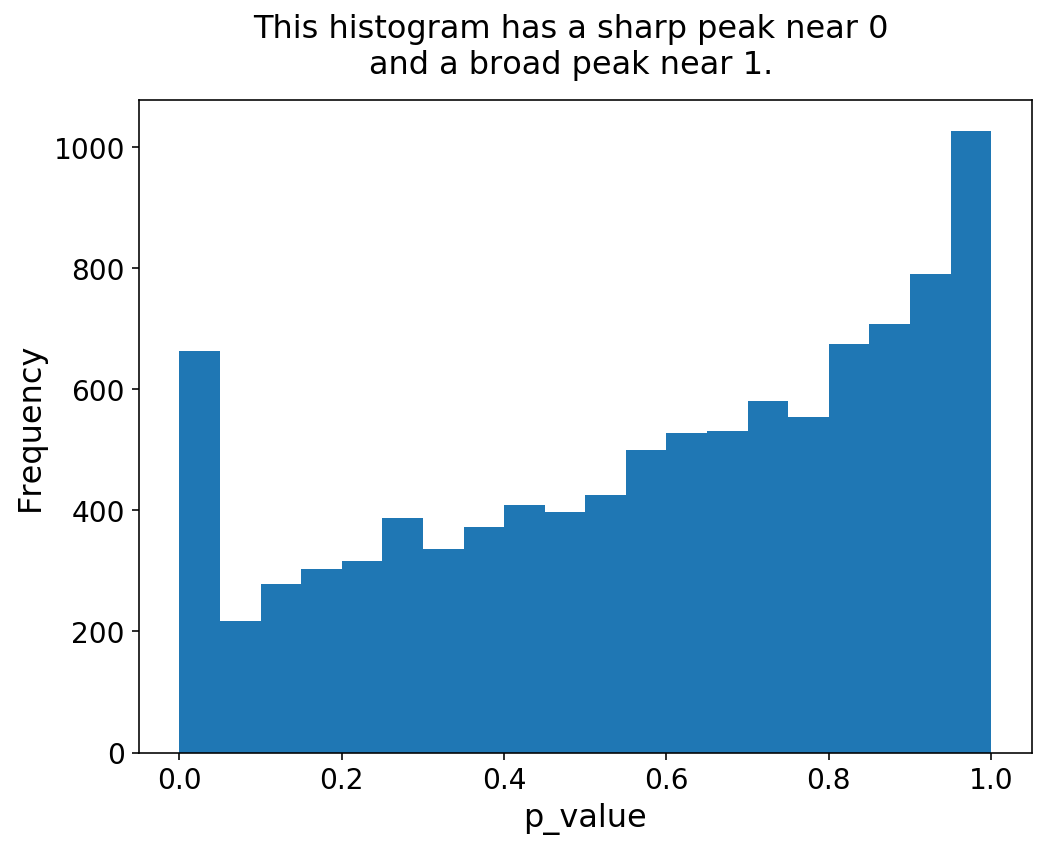

In [3]:
# --------------Step 1: Generate artifical data --------------------------

S= 10000
N_list_in_dataset = (chr4_df['total_depth_frw']+chr4_df['total_depth_frw'])
N_list = np.random.choice(N_list_in_dataset, S)

# Specify the theta's in the two Binomial Distributions
theta_small = 0.01
theta_big = 0.01*2.0

# the probability of the Binomial Distribution with `theta_small` 
pi_1 = 0.95

# the probability of the Binomial Distribution with `theta_big`
pi_2 = 1e0 - pi_1

# randomly choose one Binomial Distribution according to their probabilities
which_binom = np.random.choice([0,1], size = S, p = [pi_1, pi_2])

# Draw n randomly from the Binomial Mixture with K = 2 components
# pi_1 * Binom(n|N, theta_small) + pi_2 * Binom(n|N, theta_big)
n_list = []
for i in range(len(N_list)):
    N = N_list[i]
    
    choose_binom = which_binom[i]
    if choose_binom == 0:
        theta = theta_small
    else:
        theta = theta_big
        
    Binom = binom(N,theta)
    n = Binom.rvs(size = 1)[0]
    n_list.append(n)
    
n_list = np.array(n_list)


# --------------Step 2: Calculate p-values --------------------------

Ns_sum = N_list.sum()
ns_sum = n_list.sum()
p_value_list = []
for i in range(len(n_list)):
    Ni = N_list[i]
    ni = n_list[i]
    M = Ns_sum - Ni
    m = ns_sum - ni
    alpha = m + 1
    beta = M - m +1
    
    # bbn_i means beta_binomial_for_Sample_i for the position in consideration
    bbn_i = betabinom(Ni,alpha,beta)
    
    # calculate p-value for Sample i in this row
    p_value_i = bbn_i.sf(ni - 1)
    p_value_list.append(p_value_i)


#-----------Step 3: Plot the histogram of p-values----------------------------

fig, axes = plt.subplots(1, 1, figsize = (8,6))
axes.hist(p_value_list, bins = 20)
axes.set_xlabel('p_value', size = label_size)
axes.set_ylabel('Frequency', size = label_size)
axes.tick_params(labelsize = tick_size)
fig.suptitle('''This histogram has a sharp peak near 0
and a broad peak near 1.''', \
             y = 0.98, size = label_size, ha = 'center')
plt.show()

The histogram above implies that there may be more than one error rates in the DNA sequencing data. 

Therefore, in reality, the error rate is not a single value. We think that a mixture of a number of Binomial Distributions may describe the error rates in reality better than assuming a single Binomial Distribution. In order to test this, we first need to establish a Binomial Mixture Model with $K$ components, where $K$ could be 1, 2, 3, etc.

## Binomial Mixture Model (BMM)

I write an [article on medium.com](https://medium.com/@jingluan.xw/binomial-mixture-model-with-expectation-maximum-em-algorithm-feeaf0598b60) explaining the details of the model. The general formula for the pmf is

$\sum_{\ell =1 }^{K} \pi_\ell \mathrm{Binom}(n | N, \theta_\ell)$, 

where $\sum_{\ell=1}^{K} \pi_\ell = 1$.

The concept is similar to a Gaussian Mixture Model which is commonly adopted in statistical studies. I write up a [object-oriented script named BinomialMixture_object.py](https://github.com/jingluan-xw/Binomial-Mixture-Model-with-EM-Algorithm/blob/master/BinomialMixture_object.py) for the Binomial Mixture Model in my github. It follows the idea of `sklearn.GaussianMixture`. I define a `class` called `BinomialMixture` which contains a number of handy methods. One needs to specify $K$, the number of components in the mixture, when defining an object in this class.

* The `.fit()` method takes in pairs of (N,n) and fit a $K$-component BinomialMixture model to them. The method would fit the parameters below

    $\Theta = \{ (\pi_k, \theta_k) | k=1, 2, ..., K\}$.


* The `.predict()` method takes in a new set of (N,n) pairs and predict the posterior probabilities for them to belong to each component of the $K$-component Binomial-Mixture.


* The `.calc_AIC_BIC()` method calculates the Akaike Information Criterion and the Bayesian Information Criterion. Both criterion takes into account of both how well the model fits the data (namely log likelihood) and how complicated the model is (namely the number of free parameters in the model). 


* The `.p_value()` method calculates the p-values associated with the (n, N) pairs in a test dataset based on a Binomial Mixture Model fitted to (n, N) pairs in a training dataset.

We run the python script [fit_BMM_various_K](https://github.com/jingluan-xw/Binomial-Mixture-Model-with-EM-Algorithm/blob/master/fit_BMM_various_K.py) which calls `BinomialMixture_object` and fits the data with various values of $K = 2, 3, 4, 5, 6, 7, 8$. 

The greater $K$, the better the model fits the input data. However, a greater $K$ increases the complexity of the model and thus such a model may not generalize well to data that it has never "seen" before. This is an exhibitation of the bias-variance tradeoffs. __Akaike Information Criterion__ is defined below,

`AIC` $= -{2\over S} \log L + {2(2K+1)\over S}$,

where $S$ is the number of samples in the dataset, $(2K+1)$ is the number of parameters in the Binomial-Mixture model, and $\log L$ is the `log_likelihood`. The `log_likelihood` is the log (natural base) of the probability of $\Theta$ given the observed data set. As shown in its definition, the `AIC` compensates the `log_likelihood` by the complexity of the model. 

`AIC` decreases as $K$ increases mainly because a more complicated model fits the training data better. At a certain value of $K$, the decreasing rate significantly slows down. Beyond this $K$, increasing the model's complexity no longer improves the fitting by much. We shall choose this value of $K$ as the optimal choise of $K$.

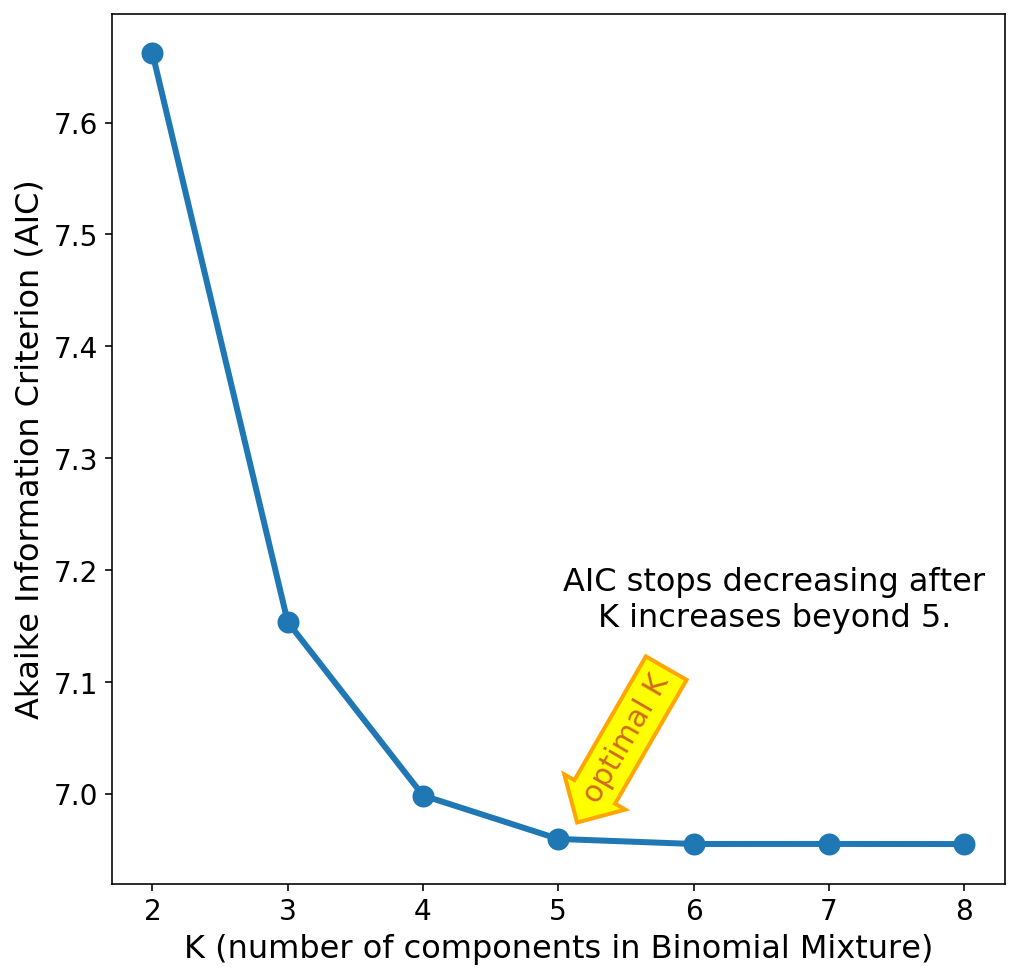

In [4]:
# list of values of K 
K_list = range(2,9)

# list of values of AIC corresponding to the list of K
AIC_list = torch.load("AIC_list.pt", map_location=torch.device('cpu'))

# plot K versus AIC
fig, axes = plt.subplots(1, 1, figsize = (8,8))
axes.plot(K_list, AIC_list, 'o-', ms=10, linewidth = 3)
axes.set_xlabel("K (number of components in Binomial Mixture)", size = label_size)
axes.set_ylabel("Akaike Information Criterion (AIC)", size = label_size)
axes.tick_params(labelsize = tick_size)
bbox_props = dict(boxstyle = "larrow, pad=0.3", fc = "yellow", ec = "orange", lw = 2)
t = axes.text(5.5, 7.05, "optimal K", ha = "center", va = "center", rotation = 60,
              size = 15,color = 'chocolate', bbox = bbox_props)
fig.suptitle('''AIC stops decreasing after
K increases beyond 5.''', x = 0.7, y = 0.4, size = label_size)
plt.show()

## Hypothesis Test Assuming BMM with $K$ Components

We calculate p-values assuming that the error rate follows a Binomial Mixture Model (BMM) with K components. We adopt $K = 1, 2, ..., 8$. The details are in [this python script](https://github.com/jingluan-xw/Binomial-Mixture-Model-with-EM-Algorithm/blob/master/Hypothesis_Test_assuming_BMM.py). We summarize the steps for p-value calculation below.

* Step 1: Shuffle the whole data set and divide it into 5 equal parts.


* Step 2: Speciy a value of $K$. 


* Step 3: Holding out one part (20%) of the data set. We call this part as the "test" data set because it does not participate in the fitting of the BMM.


* Step 4: Use the rest 80% of the data set as a training set. Feed this set into `BinomialMixture` and fit a BMM with K components.


* Step 5: Assuming that the error rate in the held-out "test" data set follows the BMM fitted to the training set, we calculate the p-values for the "held-out" data set.


* Step 6: Repeat Step 3, 4, 5 until every part of the data set has been held out and has their p-values calculated.


* Step 7: Go to Step and change the value of K.

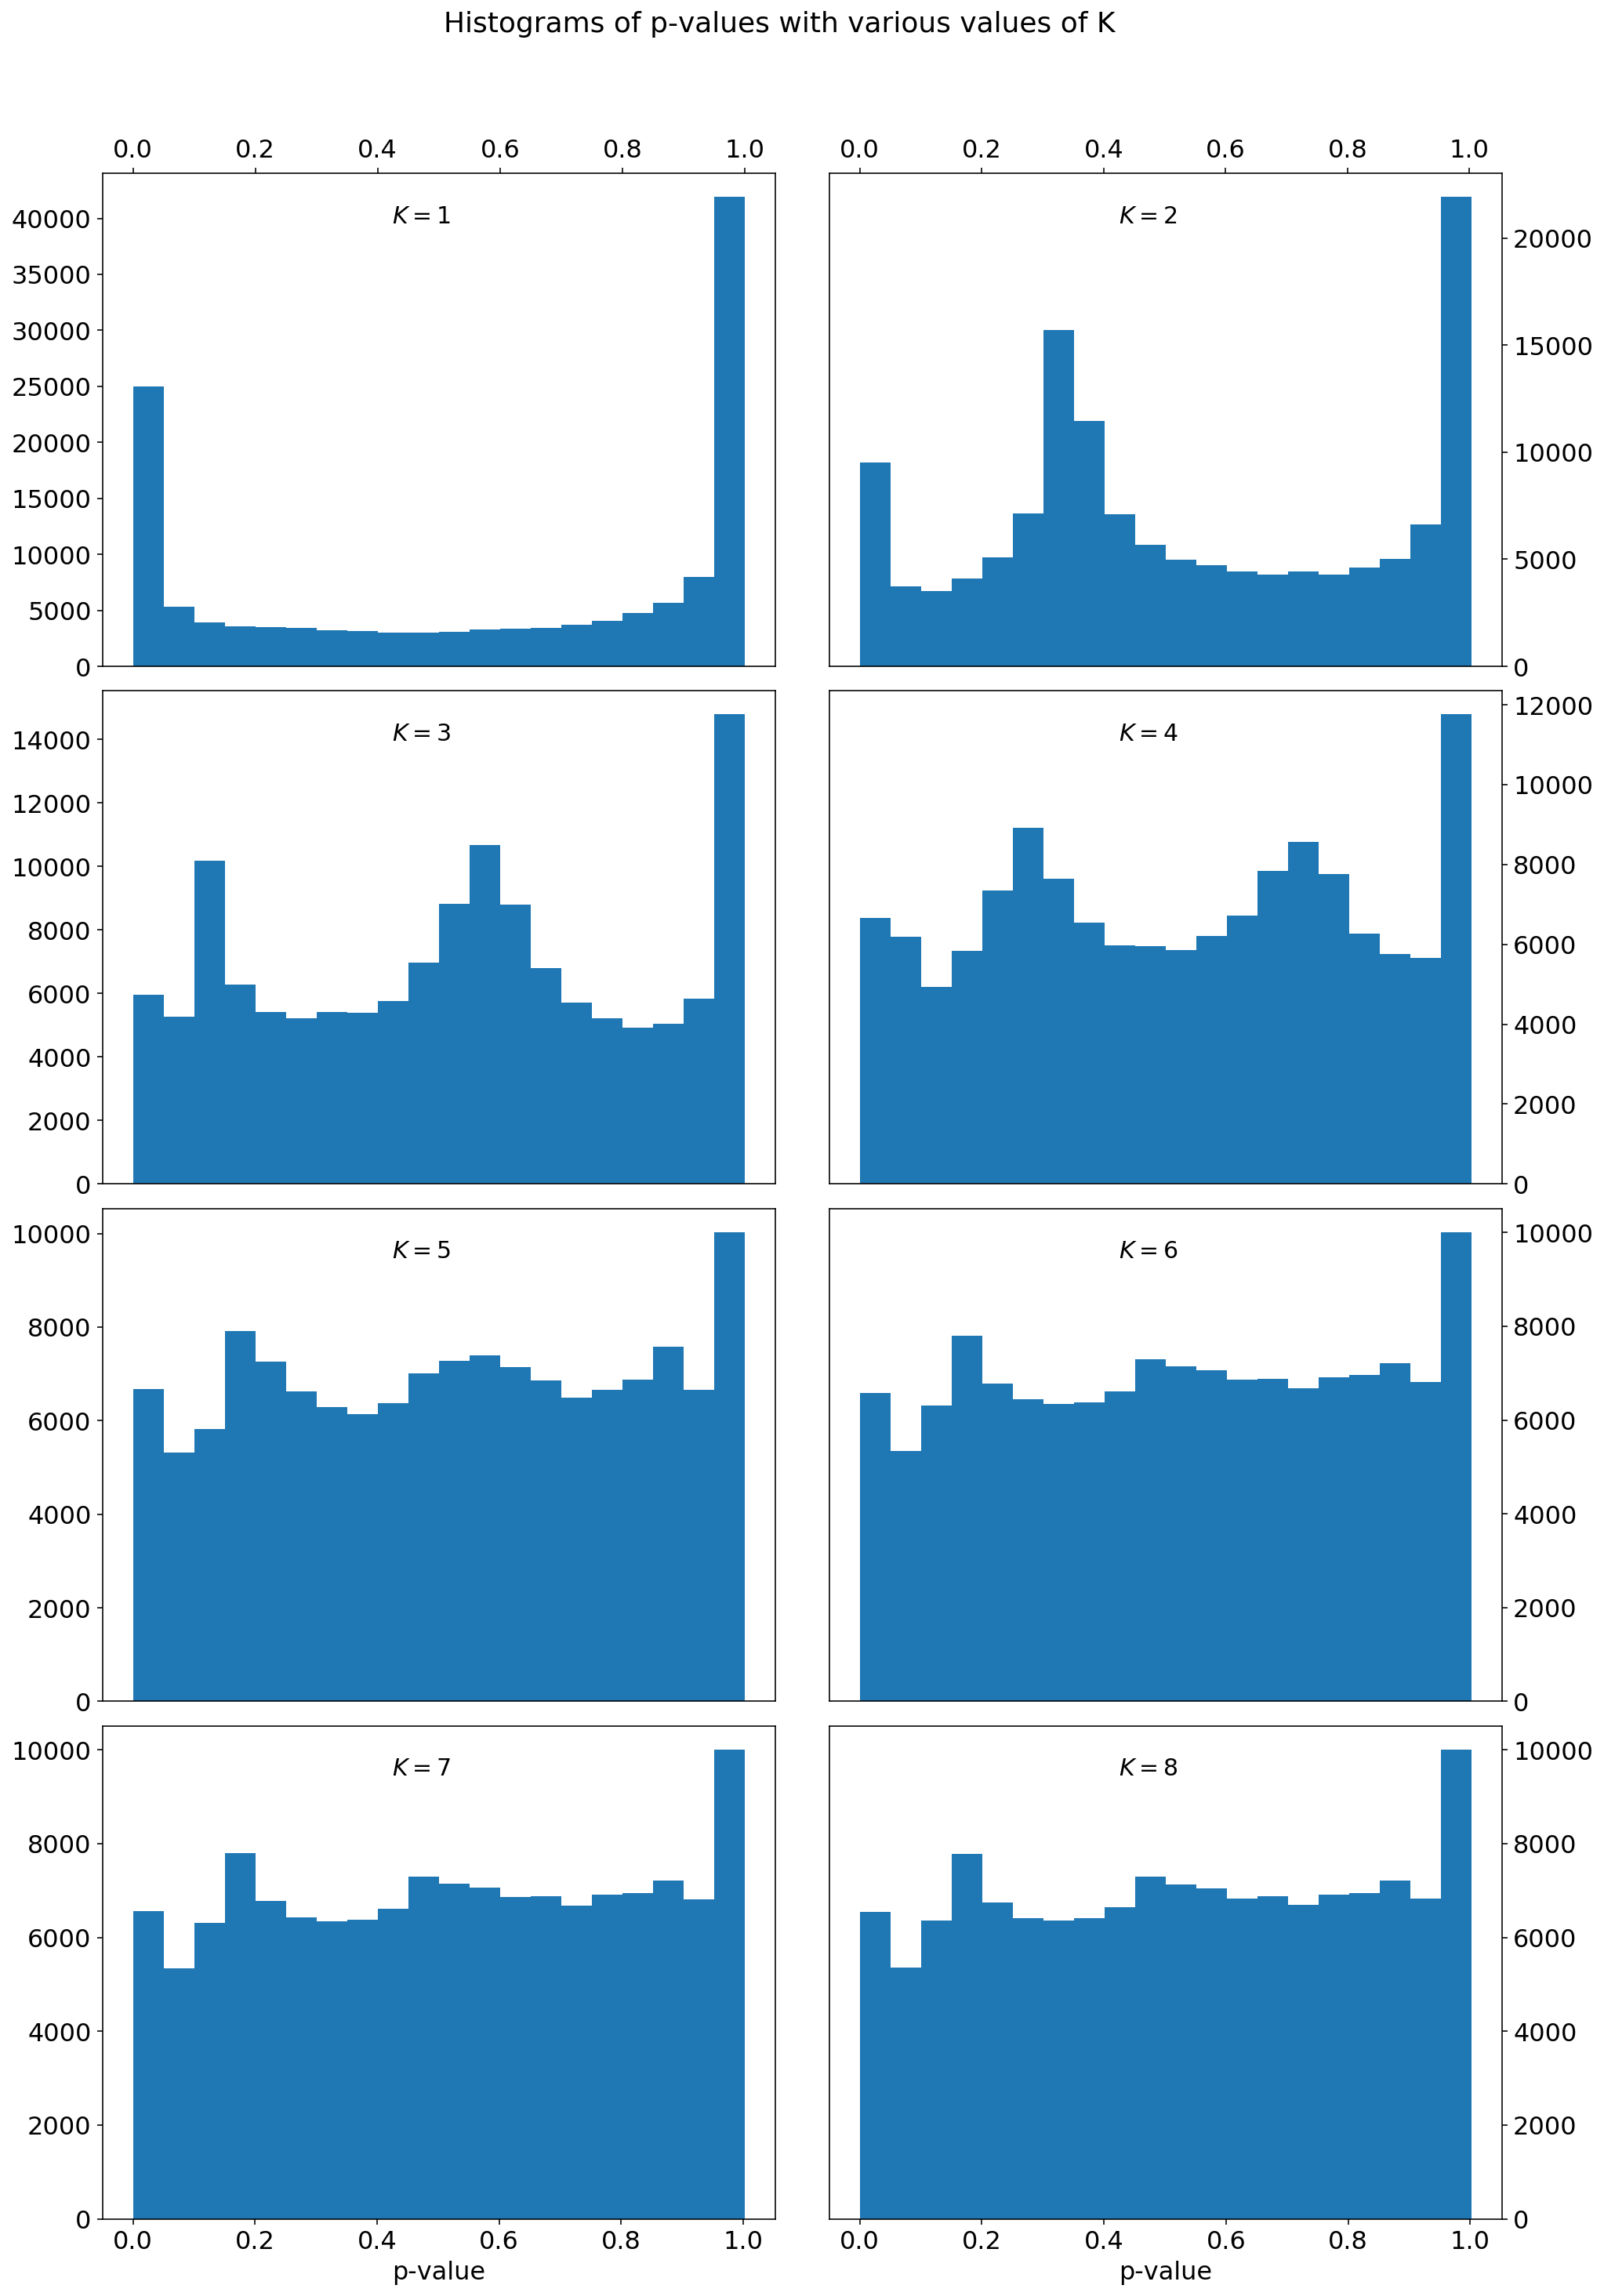

In [5]:
import matplotlib.gridspec as gridspec

# to make the heading of the figure below look better
print("\n") 

fig = plt.figure(figsize = (16, 24))
grid = gridspec.GridSpec(4, 2)
grid.update(wspace=0.08, hspace=0.05) 

for row in range(0, 4):
    for col in range(0, 2):
        K = 2 * row + col + 1
        nNp_df_K = pd.read_csv("../Output_files/nNp_df_K"+str(K)+".csv")
        axes = plt.subplot(grid[K-1])
        axes.hist(nNp_df_K['pvalue'], bins = 20)
        if row == 0:
            axes.tick_params(labelsize = label_size, bottom = False, top = True, labelbottom = False, \
                             labeltop = True)
        elif row == 3:
            axes.tick_params(labelsize = label_size)
            axes.set_xlabel('p-value', size = label_size)
        else:
            axes.tick_params(labelsize = label_size, bottom = False, labelbottom = False)
        if col == 1:
            axes.tick_params(left = False, right = True, labelleft = False, labelright = True)
            
        axes.text(0.43, 0.9, f"$K=${K}", size = 15, transform = axes.transAxes)

fig.suptitle('''Histograms of p-values with various values of K''', size = label_size+2, y = 0.94)
plt.show()

We make two observations of the figure above and raise one question.

* With K=1, the histogram of p-values has peaks near p=0 and p=1. As K increases, the histogram get more and more flat. It indicates that a BMM model with greater K simulates the error rate better.


* The peak close to `p_value = 0` disappears as the overall histogram flattens. No peak near p=0 means that 'no real mutations' in the DNA sequencing data set. 


* The peak close to `p_value = 1` still persists. The question arises whether this peak is statistically significant.

## Statistical Significance of Peaks in the Histograms

All p-value histograms show some peaks in some bins, i.e. the numbers of p-values falling within these bins look bigger than the rest. We will use a method called [**Quality Control**](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6164648/) to check the statistical significance of these peaks. In the figures above, there are $20$ bins, and thus the width of each bin is $b=1/20=0.05$. There are $m = S = 138421$ p-values. We assume that the probability for the number of p-values falling within each bin follows the [Binomial distribtuion](https://en.wikipedia.org/wiki/Binomial_distribution), Binom($x_i$|m,b), for $i=1,2,...,(1/b)$. We need to find a criterion, $\tilde n$, such that __the probability of any of the $1/b=20$ bins has $x_i>\tilde n$ is smaller than $b=0.05$__. In other words, if $x_i>\tilde n$, we would say that the peak at this bin (ith bin) is significant. Now we want to find the $\tilde n$ so that the probability for mistaking one or more bins for being statistically significant within $b=0.05=5\%$. The probability for mistaking one or more non-significant events for significant events is also known as the [family-wise error rate](https://en.wikipedia.org/wiki/Family-wise_error_rate). That is to say, we need the following condition to be satisfied,

$P(\bigcup_{i=1}^{1/b} \{x_i > \tilde n\} )\leq \sum_{i=1}^{1/b} P(x_i>\tilde n) = {1\over b}\left(1-\mathrm{Binom(m, b).cdf}(\tilde n)\right)\,\, \leq b$\, 

where $\bigcup$ means the union of sets. Here $\bigcup_{i=1}^{1/b} \{x_i>\tilde n\}$ means $x_1>\tilde n$ or $x_2>\tilde n$, ...., or $x_{1/b} >\tilde n$. The $\mathrm{Binom.cdf}$ means the cummulative ditribution function for the Binomial distribution. The equation above reduces to

$\mathrm{Binom(m, b).cdf}(\tilde n) \geq 1 - b^2 = 0.9975$.

The procedure which leads to the equation above is the same as the consideration of [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction).



statistically significance level = 7150
The number of evens in one bin must exceed 7150 to be regarded as significant.



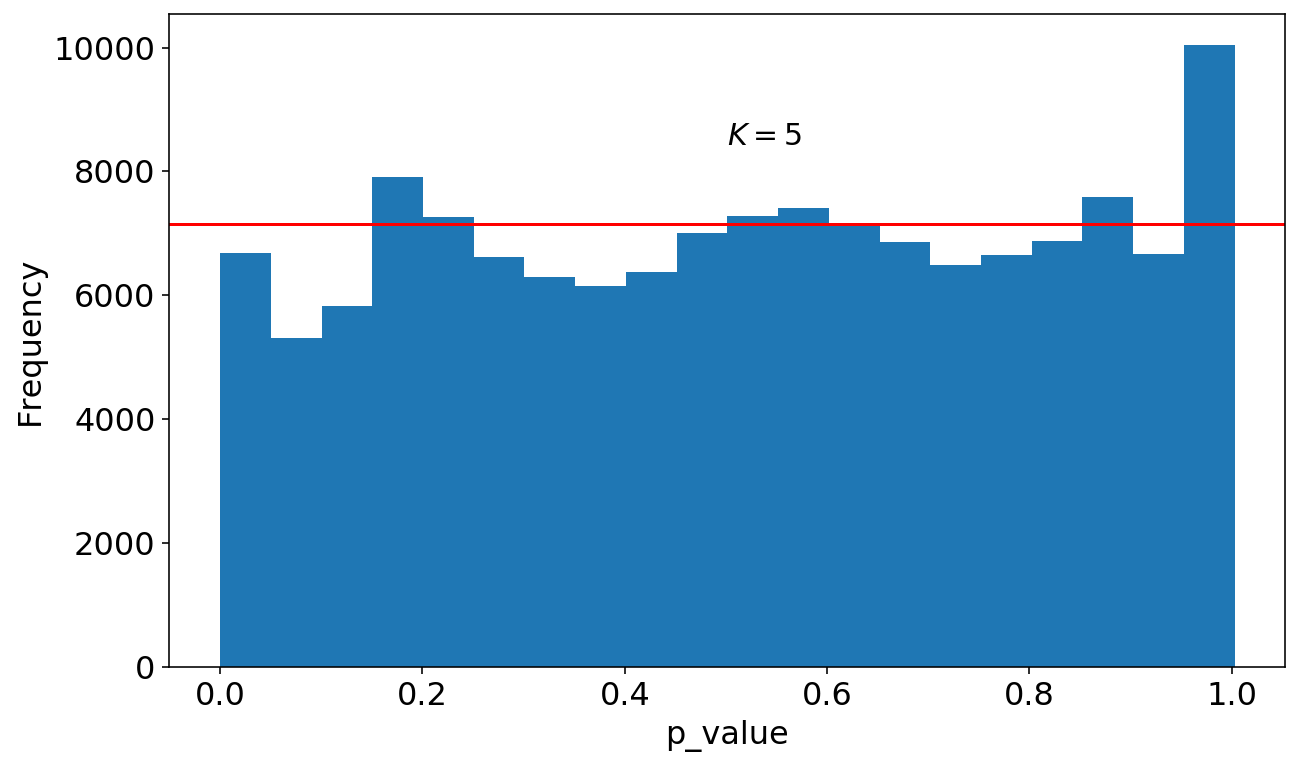

In [6]:
# Define a binom function 
Binom_bin = binom(138421, 0.05)

# percent point function is the inverse function of cdf
sig_level = int(Binom_bin.ppf(q=0.9975))

print("\n")
print(f"statistically significance level = {sig_level}")
print(f"The number of evens in one bin must exceed {sig_level} to be regarded as significant.\n")

nNp_df_5 = pd.read_csv("../Output_files/nNp_df_K"+str(5)+".csv")
fig, axes = plt.subplots(1, 1, figsize = (10, 6))
axes.hist(nNp_df_5['pvalue'], bins = 20)
axes.axhline(y = sig_level, color = 'r')
axes.set_xlabel('p_value', size = label_size)
axes.set_ylabel('Frequency', size = label_size)
axes.tick_params(labelsize = label_size)
axes.text(0.5, 0.8, "$K=5$", size = 15, transform = axes.transAxes)
plt.show()

Although the peak near `p_value = 1` is statistically significant, the corresponding $(n, N)$ pairs have very small Allele Frequency $n/N \ll 1$. Such low Allele Frequencnies are most likely due to random DNA sequencing errors and thus they are not interesting in bio-medical sense. They still make a significant peak near 1 because the BMM model does not well simulate such low error rate. We won't devote much efforts to understanding this peak because the $(n, N)$ in this peak are not interesting biomedically.

## Main Contribution: 

Excluding fake signals in the peak near $p=0$. Those are due to sequencing errors but not mutations!

## Next Step is to Validate This Algorithm

It is not surprising that there is no real mutation in this data set. However, we still need to check whether this algorithm can filter out real mutations when there are some real mutations. We will apply this algorithm to the gene "TP53" which is known as the cancer gene because mutations of this gene are common among cancer cells of all kinds of types.